# Imports

In [1]:
!pwd
import sys
sys.path.append("..")
from bumps.names import Curve, fit, FitProblem
from bumps.dream.state import load_state
import matplotlib.pyplot as plt
import numpy as np
import scipy.fft as fft
import os
import math

from scattertools.support import molstat
from molgroups import mol
from molgroups import lipids


/Users/frank/Documents/programming/molgroups/examples/data_fitting/diffraction/DOPC


# Variables

In [2]:
ed2sld = 2.814e-5
bulksld = 0.334 * ed2sld
# bulk sld used during form factor calculation from experimental data

maxarea = 100
stepsize = 0.1

#make sure dimension is odd
dimension = 1501
startz = 50

# fit setup
store = "fit_1"
setupdir = os.getcwd()
runfile = "run"
fitsource = "bumps"

if not os.path.isdir(store):
    os.mkdir(store)

run = True
burn = 2000
steps = 100

# Functions

In [3]:
def getSLD(aArea, aSL, normArea, bulksld):
    aSLD = np.zeros(dimension).tolist()
    
    # bulksld_ffc can be replaced by bulksld if it is assumed that during form factor calculation
    # the correct subtraction was applied
    
    for i in range(dimension):
        if aArea[i] != 0:
            aSLD[i] = aSL[i] / (aArea[i] * stepsize) * aArea[i] / normArea + bulksld * (1 - aArea[i] / normArea)
        else:
            aSLD[i] = bulksld
    return aSLD


In [4]:
def symmetrize(aSLD, bulksld):
    center = bilayer.fnGetCenter()
    center = int(center/stepsize+0.5)
    canvas_center = len(aSLD) // 2
    n = int(canvas_center - center)
    centered_bilayer = np.roll(aSLD, n)
    symmetrized_bilayer = np.add(centered_bilayer, centered_bilayer[::-1]) * 0.5
    symmetrized_bilayer -= bulksld
    return symmetrized_bilayer


In [5]:
def computeFormFactor(lq, aSLD, prefactor, dq, offset, stepsize, DCTtype=1):

    half_bilayer = aSLD[int(len(aSLD)/2) :]

    # TODO: Make sure that lq and x are roughly comparable
    # dimension should be odd
    dct_dimension = 5001
    
    # DCT is unnormalized, except for stepsize, which ensures that FO obeys the integral norm
    F = fft.dct(half_bilayer, n=dct_dimension, type=DCTtype) * stepsize
    F = np.abs(F)
    # normalization by integral of FF
    #sum = F.sum() * np.pi / (2 * dct_dimension * stepsize) * (2 * 1) * dq
    #if sum != 0:
    #    F /= sum
    x = np.array(
        [
            np.pi / (2 * dct_dimension * stepsize) * (2 * i) * dq
            for i in range(dct_dimension)
        ]
    )

    # interpolate (x, F) onto lq -> (lq, modelform)
    return np.interp(lq, x, F, period=None) * prefactor - offset


def setBilayer(
    l_lipid, sigma, rel_pos, hg1_thickness, methyl_sigma, bulksld):

    bilayer.headgroups1[0].fnSet(length=hg1_thickness, rel_pos=[0, rel_pos, 0])
    bilayer.headgroups1[0].fnSetSigma(sigma)
    bilayer.headgroups2[0].fnSet(length=hg1_thickness, rel_pos=[0, rel_pos, 0])
    bilayer.headgroups2[0].fnSetSigma(sigma)
    bilayer.methyl_sigma[0] = methyl_sigma
    bilayer.fnSet(sigma, bulksld, startz, l_lipid, l_lipid, vf_bilayer=1)


In [6]:
def modelformfactor(
    lq,
    l_lipid,
    sigma,
#    prefactor,
#    dq,
#    offset,
    rel_pos,
    hg1_thickness,
    methyl_sigma,
):
    setBilayer(
        l_lipid,
        sigma,
        rel_pos,
        hg1_thickness,
        methyl_sigma,
        bulksld
    )

    #set all unused parameters
    dq=1.0
    prefactor = 1.0
    offset=0.

    z = np.linspace(0, dimension * stepsize, dimension, endpoint=False)
    normArea, aArea, aSL = bilayer.fnWriteProfile(z)
    aSLD = getSLD(aArea, aSL, normArea, bulksld)
    aSLD = symmetrize(aSLD, bulksld)
    modelform = computeFormFactor(lq, aSLD/ed2sld, prefactor, dq, offset, stepsize)

    # save a bunch of parameters when restoring problem states
    problem.bilayers = [bilayer]
    problem.stepsize = stepsize
    problem.dimension = dimension
    problem.sld = aSLD
    problem.moldat = bilayer.fnWriteGroup2Dict({}, 'bilayer', z)

    return modelform


# Fit Setup

In [7]:
#Load experimental data
ULV = np.loadtxt("exp_data/dopcULV.dat")
MLV = np.loadtxt("exp_data/dopcMLVs.dat")
ORI = np.loadtxt("exp_data/dopcOri.dat")
F2 = np.concatenate((ULV, MLV, ORI)) #This line is unnecessary for single file
F2 = F2[np.argsort(F2[:, 0])]
q_exp = F2[:, 0]
form_exp = F2[:, 1]
# constant error bar estimate of .05 Å
dform_exp = [0.05] * len(form_exp)

In [8]:
bilayer = mol.BLM(lipids=[lipids.DOPC], lipid_nf=[1.0], xray_wavelength=1.514)

In [9]:
l_lipid_initial = 11
sigma_initial = 2.0
rel_pos_initial = 0.5
methyl_sigma_initial = 0.1
lh1 = 9.65

In [10]:
M2 = Curve(
    modelformfactor,
    q_exp,
    form_exp,
    dform_exp,
    l_lipid=l_lipid_initial,
    sigma=sigma_initial,
#    prefactor=prefactor_initial,
#    dq=dq_initial,
#    offset=offset_initial,
    rel_pos=rel_pos_initial,
    hg1_thickness=lh1,
    methyl_sigma=methyl_sigma_initial,
)


In [11]:
M2.l_lipid.range(9, 13)
M2.sigma.range(1.0, 4.0)
#M2.prefactor.range(0.5, 1.5)
#M2.dq.range(0.95, 1.1)
#M2.offset.range(-0.1, 0.1)
M2.hg1_thickness.range(7, 12)
M2.rel_pos.range(0, 1)
M2.methyl_sigma.range(0, 3)


Parameter(methyl_sigma)

# Run the fit

In [12]:
model = M2
problem = FitProblem(model)


In [13]:
from bumps.mapper import MPMapper

mapper = MPMapper.start_mapper(problem, None, cpus=0)  # cpus=0 for all CPUs
if run:
    result = fit(
        problem,
        method="dream",
        mapper = mapper,
        samples=10,
        burn=burn,
        steps=steps,
        thin=1,
        alpha=0,
        outliers="none",
        trim="none",
        verbose=True,
    )
    res_state = result.state
    res_state.save(store + "/" + runfile)  # save chains
    problem.fitness.save(store + "/" + runfile)  # save fit plot data

else:
    print(os.getcwd() + "/" + store + "/" + runfile)
    res_state = load_state(os.getcwd() + "/" + store + "/" + runfile)
    res_state.mark_outliers()


# steps: 100, # draws: 5000
step 1 cost 36.3021(99)
                           hg1_thickness .....|....       9.65 in (7, 12)
                                 l_lipid .....|....         11 in (9, 13)
                            methyl_sigma |.........        0.1 in (0, 3)
                                 rel_pos .....|....   0.500001 in (0, 1)
                                   sigma ...|......          2 in (1.0, 4.0)
step 10 cost 36.2649(99)
step 19 cost 35.7220(99)
step 25 cost 33.8544(99)
step 31 cost 18.3406(99)
step 38 cost 5.3576(99)
step 45 cost 2.0822(99)
step 51 cost 1.4983(99)
step 60 cost 1.4983(99)
step 68 cost 1.4660(99)
step 78 cost 1.4215(99)
step 88 cost 1.4207(99)
step 96 cost 1.4207(99)
step 104 cost 1.4207(99)
step 112 cost 1.4185(99)
step 121 cost 1.4185(99)
step 129 cost 1.4185(99)
step 138 cost 1.4113(99)
step 147 cost 1.4113(99)
step 154 cost 1.4113(99)
step 159 cost 1.4113(99)
step 165 cost 1.4113(99)
step 172 cost 1.4113(99)
step 180 cost 1.4113(99)
step 188 c

/Users/frank/opt/anaconda3/envs/refl1d/lib/python3.11/site-packages/bumps/fitproblem.py:296: UserWarning: Deprecated: use of problem.fitness will be removed at some point
  warnings.warn('Deprecated: use of problem.fitness will be removed at some point')


# Analyze Fit
## Best Fit Profiles

1.4071(99)


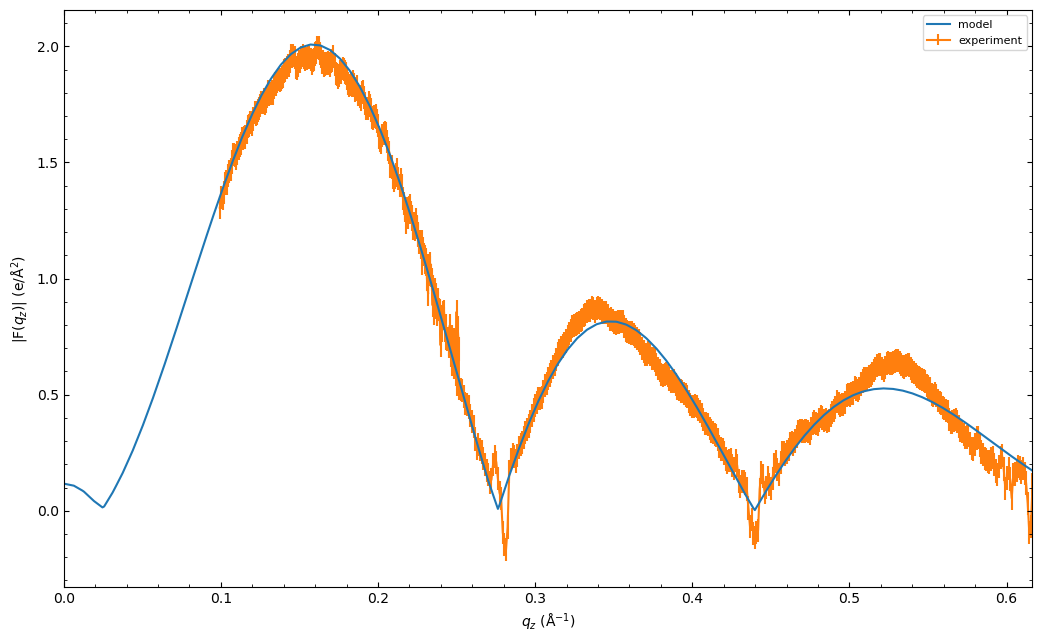

In [15]:
p = res_state.best()[0]
problem.setp(p)
print(problem.chisq_str())

q, F, dq, Fy = np.loadtxt(store + "/" + runfile + ".dat", skiprows=1).T

# This creates the q-vector to generate an output to zero and plots the theory in this range
if q[0] > 0:
    qmaxtheo = math.floor(q[0]/(q[1]-q[0]))*(q[1]-q[0])
    if qmaxtheo == q[0]:
        qmaxtheo -= stepsize
    if qmaxtheo <= 0:
        qmaxtheo = 0

    q_theo = np.linspace(0, qmaxtheo, num=int(qmaxtheo/(q[1]-q[0])))
    q_theo = np.concatenate([q_theo, q])
else:
    q_theo = q
F_theo = M2.theory(q_theo)


fig, ax = plt.subplots()
# ax.plot(q, Fy, zorder=2, label="model")
# ax.plot(q_theo, F_theo, zorder=2, label="model")
ax.plot(q_theo, F_theo, zorder=2, label="model")
ax.errorbar(q, F, dq, zorder=1, label="experiment")
ax.legend(fontsize=8)
ax.set_xlim([0, q[-1]])
ax.set_ylabel("|F($q_z$)| (e/Å$^2$)", fontsize=10)
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
ax.set_xlabel("$q_z$ (Å$^{-1}$)", fontsize=10)
ax.figure.set_size_inches(12.5, 7.5)
fig.patch.set_facecolor('white')
plt.savefig(store + "/model.png", facecolor="white")
plt.show()

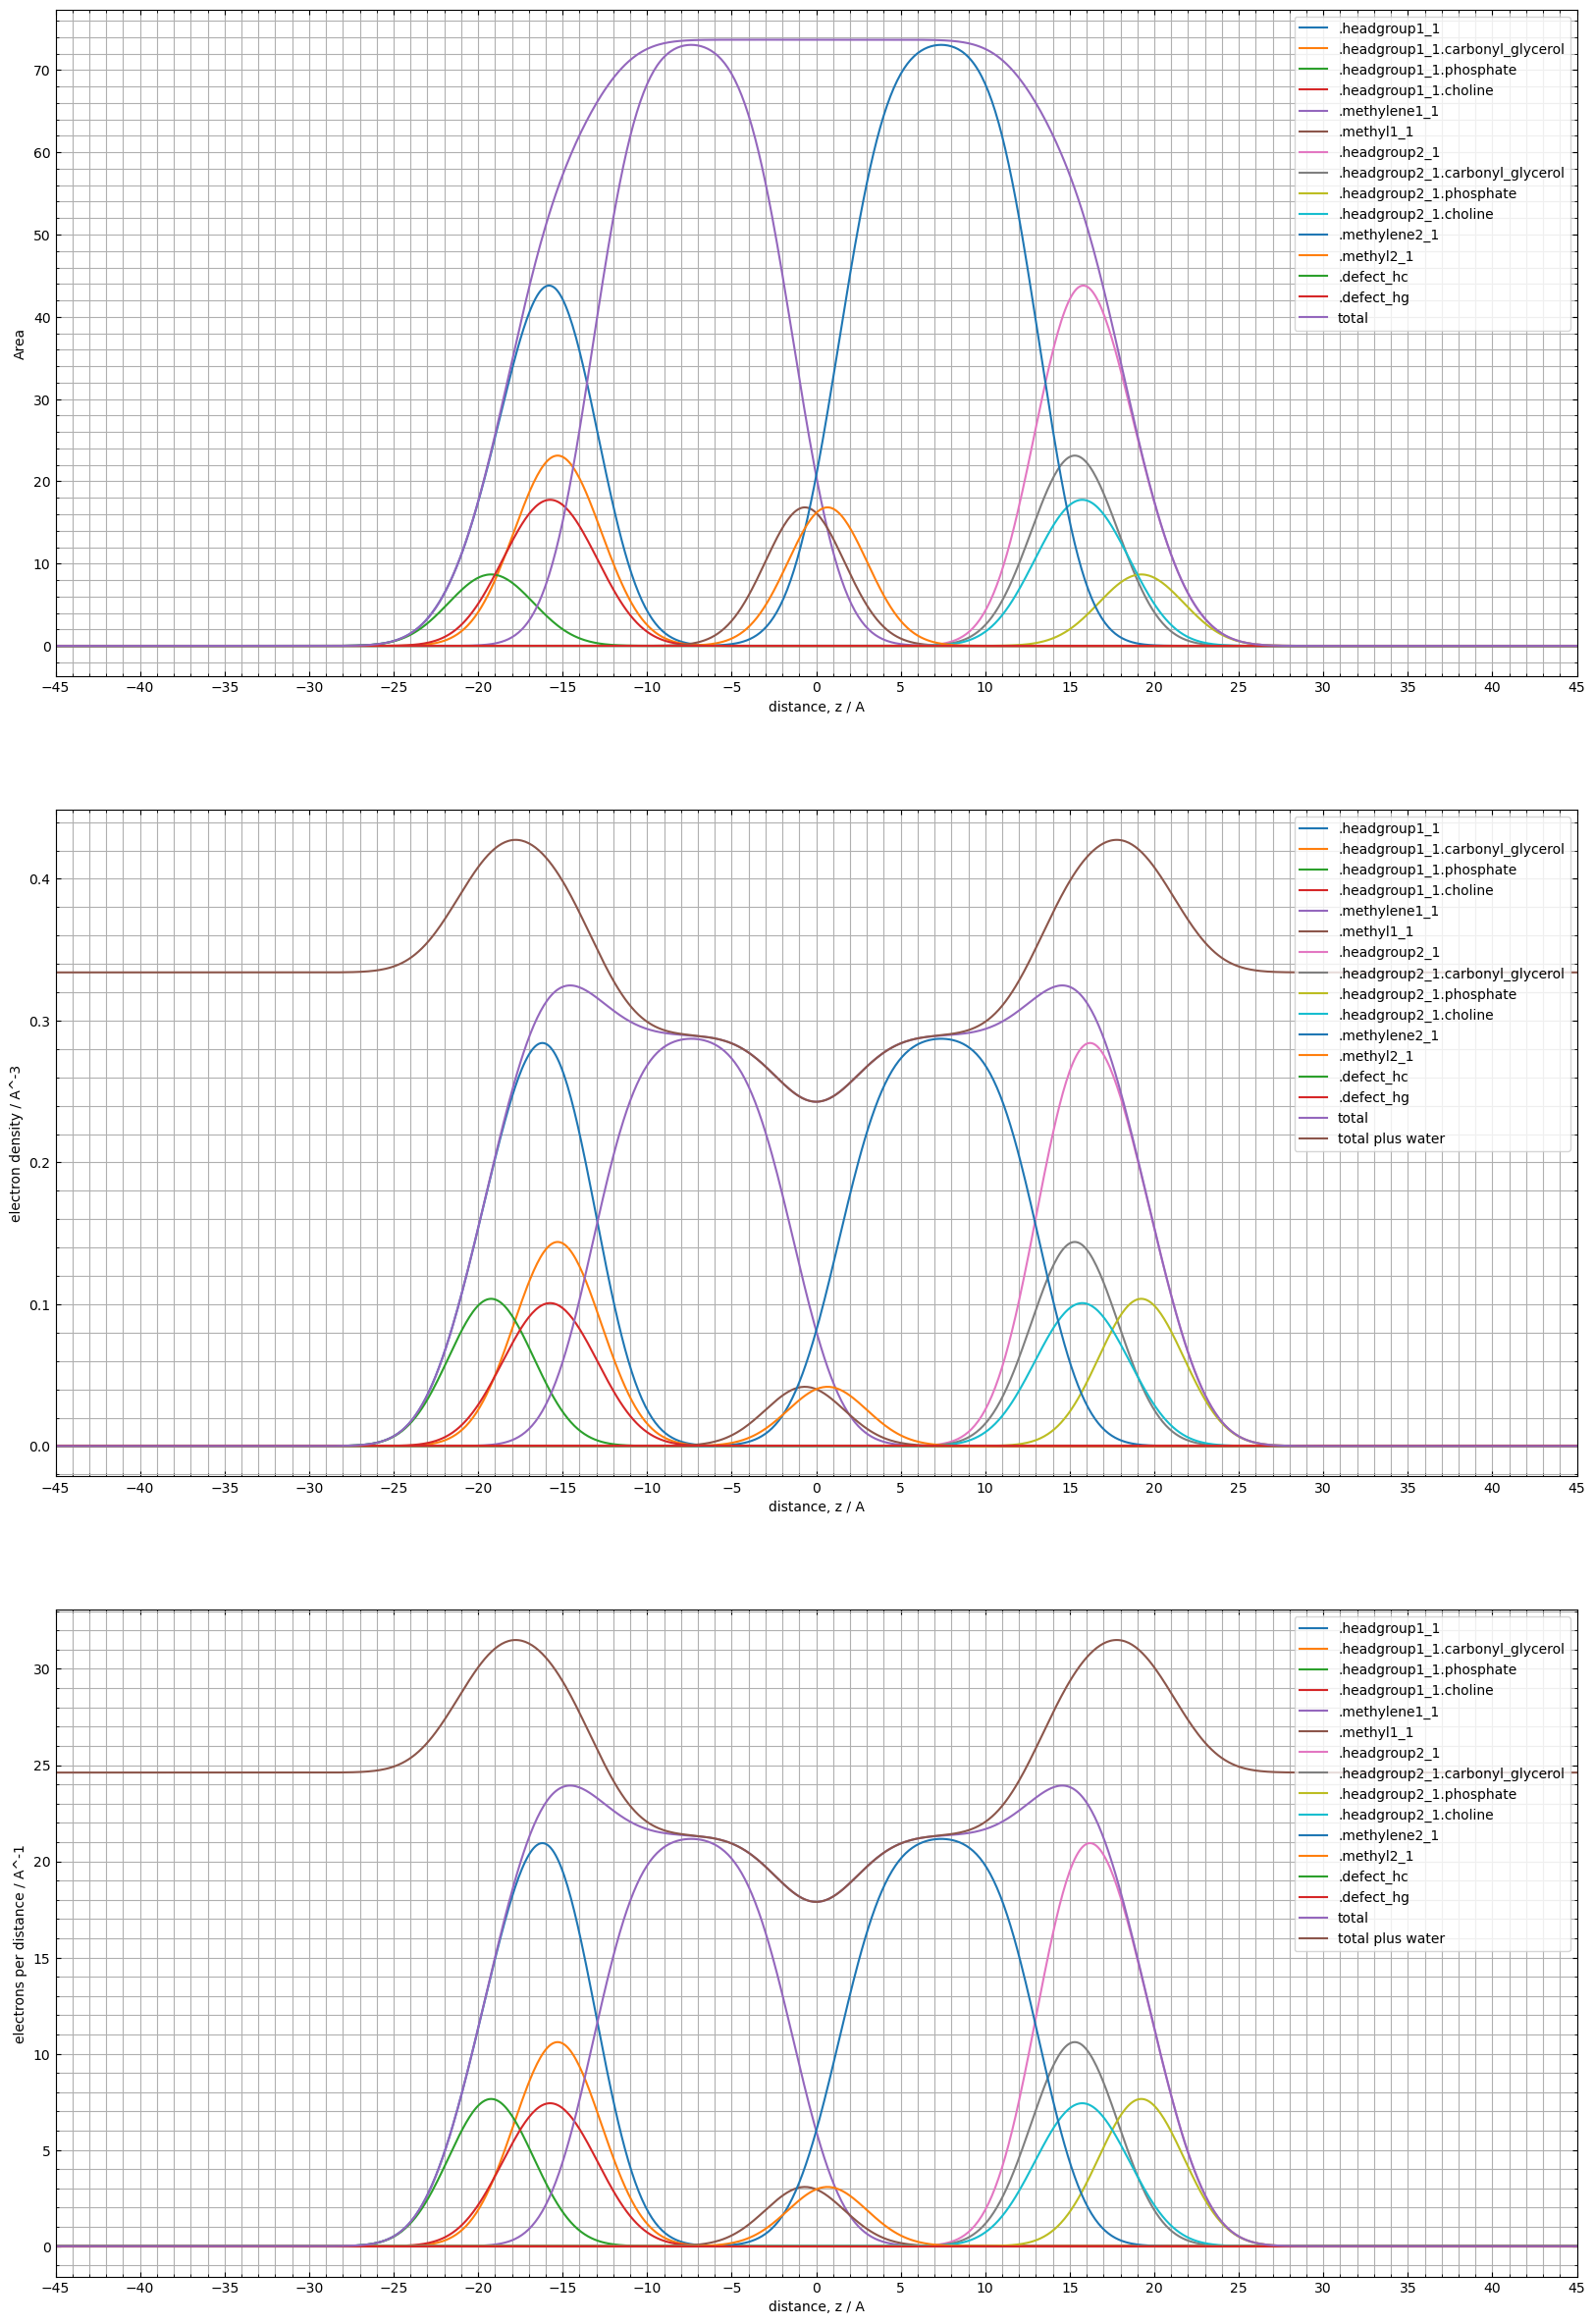

In [17]:
def plot_components(z, blm, center):
    def _add_components(obj, name, nf, center):
        for key, val in obj.__dict__.items():       # cycle over all attributes of blm
            if isinstance(val, mol.nSLDObj):        # if instance of nSLDObj, plot its profile
                ddp, aArea, anSL = val.fnWriteProfile(z)
                aArea = np.array(aArea)
                anSL = np.array(anSL)
                anSLperD = anSL / (maxarea * stepsize)
                anSLD = np.divide(anSL, aArea, out=np.zeros_like(anSL), where=aArea>0.01)
                anSLD /= stepsize
                ax[0].plot(z-center, aArea*nf, '-', label=name+'.'+val.name)
                ax[1].plot(z-center, anSLperD/ed2sld, '-', label=name+'.'+val.name)
                ax[2].plot(z-center, anSL*nf/ed2sld/stepsize, '-', label=name+'.'+val.name)
                _add_components(val, name+'.'+val.name, nf*val.nf, center)

    dd, aArea, anSL = blm.fnWriteProfile(z)
    aAreaTotal = np.array(aArea)
    anSLTotal = np.array(anSL)
    maxarea = np.amax(aArea)
    anSLplusWater = anSL + (maxarea-aArea) * stepsize * bulksld
    anSLperDTotal = anSLTotal / (maxarea * stepsize)
    anSLDTotal = np.divide(anSLTotal, aArea, out=np.zeros_like(anSLTotal), where=aArea>0.01)
    anSLDTotal /= stepsize
    anSLperDplusWater = anSLplusWater / (maxarea * stepsize)

    fig, ax = plt.subplots(3, 1, figsize=(20,30))
    fig.patch.set_facecolor('white')

    # plot individual components first
    _add_components(bilayer, "", 1., center)

    ax[0].plot(z-center, aAreaTotal, label='total')
    ax[1].plot(z-center, anSLperDTotal/ed2sld, label='total')
    ax[1].plot(z-center, anSLperDplusWater/ed2sld, label='total plus water')
    ax[2].plot(z-center, anSLTotal/ed2sld/stepsize, label='total')
    ax[2].plot(z-center, anSLplusWater/ed2sld/stepsize, label='total plus water')
    ax[0].set_ylabel('Area')
    ax[1].set_ylabel('electron density / A^-3')
    ax[2].set_ylabel('electrons per distance / A^-1')
    ax[0].set_xlabel('distance, z / A')
    ax[1].set_xlabel('distance, z / A')
    ax[2].set_xlabel('distance, z / A')


    for i in range(3):
        ax[i].legend(loc=0)
        ax[i].legend(loc="upper right")
        ax[i].minorticks_on()
        ax[i].tick_params(which="both", direction="in", labelsize=10)
        ax[i].tick_params(bottom=True, top=True, left=True, right=True, which="both")
        ax[i].set_xlim(-45, 45)
        ax[i].set_xticks(np.arange(-45, 46, 5.0))
        ax[i].grid(True, which='Both')
    fig.patch.set_facecolor('white')
    plt.savefig(store + "/best", facecolor="white")
    plt.show()

bilayer = problem.bilayers[0]
# center around methyl distribution
center = bilayer.methyl1_1.z + 0.5 * bilayer.methyl1_1.length
z = np.arange(dimension) * stepsize
bilayer.fnAdjustParameters()
plot_components(z, bilayer, center)

## Statistical Analysis

In [18]:
from bumps.dream.stats import var_stats, save_vars

print("final chisq", problem.chisq_str())
draw = res_state.draw(portion=1)
all_vstats = var_stats(draw)
save_vars(all_vstats, store + "/" + runfile + ".json")


final chisq 1.4071(99)


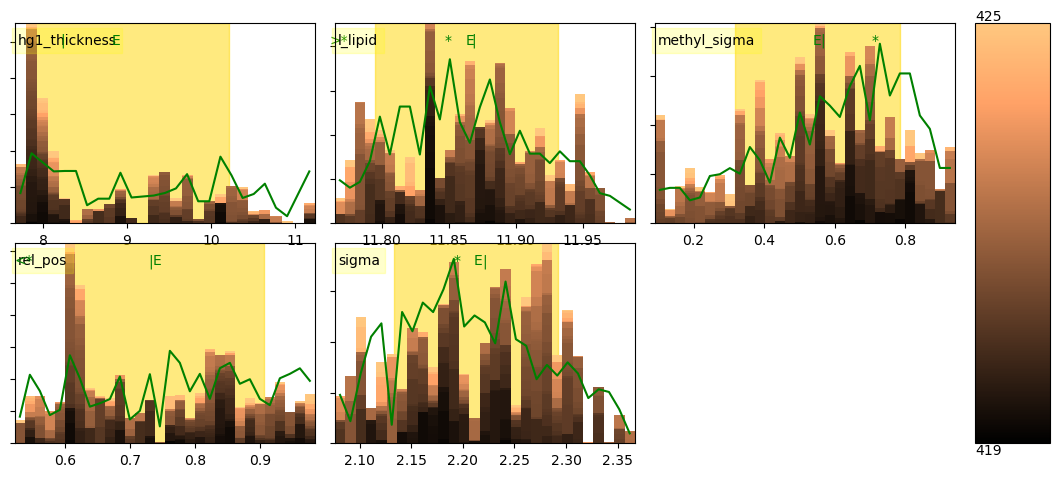

In [19]:
from bumps.dream import corrplot, varplot
from pylab import figure, savefig

err = sys.stderr
sys.stderr = open("/dev/stderr", "w")
figure(figsize=varplot.var_plot_size(len(all_vstats)))
nbins = max(min(draw.points.shape[0] // 10000, 400), 30)
varplot.plot_vars(draw, all_vstats, nbins=nbins)
if run:
    savefig(store + "/var", facecolor="white")
else:
    savefig(store + "/var_reloaded", facecolor="white")
sys.stderr = err


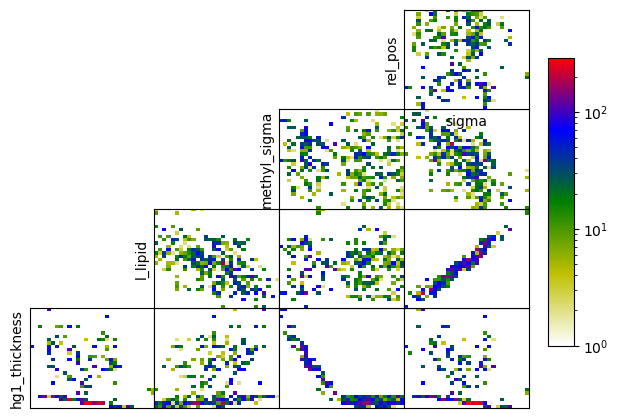

In [20]:
if draw.num_vars <= 25:
    figure()
    c = corrplot.Corr2d(draw.points.T, bins=nbins, labels=draw.labels)
    c.plot()
if run:
    savefig(store + "/corr", facecolor="white")
else:
    savefig(store + "/corr_reloaded", facecolor="white")


In [22]:
p = res_state.best()[0]
problem.setp(p)
print(problem.chisq_str())


1.4071(99)


In [23]:
import os

if run:
    if os.path.isfile(store + "/sErr.dat"):
        os.remove(store + "/sErr.dat")
    if os.path.isfile(store + "/isErr.dat"):
        os.remove(store + "/isErr.dat")
    if os.path.isfile(store + "/StatDataPython.dat"):
        os.remove(store + "/StatDataPython.dat")

fit_analysis = molstat.CMolStat(
    fitsource=fitsource,
    spath=setupdir,
    mcmcpath=store,
    runfile=runfile,
    state=res_state,
    problem=problem,
)


In [24]:
sparse = 0.005
fit_analysis.fnAnalyzeStatFile(fConfidence=-1, sparse=sparse)


No StatDataPython.dat.
Recreate statistical data from sErr.dat.


AttributeError: 'Curve' object has no attribute 'sld'

In [25]:
fit_analysis.fnCreateBilayerPlotData()

AttributeError: 'CMolStat' object has no attribute 'fnCreateBilayerPlotData'

In [26]:
fit_analysis.fnCalculateMolgroupProperty(fConfidence=-1)

AttributeError: 'CMolStat' object has no attribute 'fnCalculateMolgroupProperty'

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import sys

bilayer_plot_data = pd.read_csv(
    store + "/bilayerplotdata.dat", sep="\s", engine="python"
)

# use methyl groups to align plot
methyls = bilayer_plot_data["innerch3_corr_cvo"]+bilayer_plot_data["outerch3_corr_cvo"]
center = np.argmax(methyls) * stepsize
zax = bilayer_plot_data["zaxis"] -center

fig, ax = plt.subplots()
ax.plot(zax, bilayer_plot_data["water_corr_cvo"], label="water")
ax.plot(zax, bilayer_plot_data["innerhg_corr_cvo"] + bilayer_plot_data["outerhg_corr_cvo"], label="headgroups")
ax.plot(zax, bilayer_plot_data["inner_cg_corr_cvo"] + bilayer_plot_data["outer_cg_corr_cvo"],label="cg")
ax.plot(zax, bilayer_plot_data["inner_phosphate_corr_cvo"] + bilayer_plot_data["outer_phosphate_corr_cvo"], label="phosphate")
ax.plot(zax, bilayer_plot_data["inner_choline_corr_cvo"] + bilayer_plot_data["outer_choline_corr_cvo"], label="choline")
ax.plot(zax, bilayer_plot_data["innerhc_corr_cvo"]+bilayer_plot_data["outerhc_corr_cvo"], label="hydrocarbons")
ax.plot(zax, bilayer_plot_data["innerch2_corr_cvo"]+bilayer_plot_data["outerch2_corr_cvo"], label="CH2")
ax.plot(zax, bilayer_plot_data["innerch3_corr_cvo"]+bilayer_plot_data["outerch3_corr_cvo"], label="CH3")
ax.legend(loc="upper right")
plt.xlabel("Distance (Å)")
plt.ylabel("Component volume occupancy")
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
plt.xlim(-35, 35)
plt.xticks(np.arange(-35, 36, 5.0))
plt.grid(True, which='Both')
fig.patch.set_facecolor('white')
ax.figure.set_size_inches(16, 10)
plt.savefig(store + "/cvo", facecolor="white")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'fit_1/bilayerplotdata.dat'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import sys

bilayer_plot_data = pd.read_csv(
    store + "/bilayerplotdata.dat", sep="\s", engine="python"
)

fig, ax = plt.subplots()
ax.plot(zax, bilayer_plot_data["water_corr"], label="water")
ax.plot(zax, bilayer_plot_data["innerhg_corr"] + bilayer_plot_data["outerhg_corr"], label="headgroups")
ax.plot(zax, bilayer_plot_data["inner_cg_corr"] + bilayer_plot_data["outer_cg_corr"],label="cg")
ax.plot(zax, bilayer_plot_data["inner_phosphate_corr"] + bilayer_plot_data["outer_phosphate_corr"], label="phosphate")
ax.plot(zax, bilayer_plot_data["inner_choline_corr"] + bilayer_plot_data["outer_choline_corr"], label="choline")
ax.plot(zax, bilayer_plot_data["innerhc_corr"]+bilayer_plot_data["outerhc_corr"], label="hydrocarbons")
ax.plot(zax, bilayer_plot_data["innerch2_corr"]+bilayer_plot_data["outerch2_corr"], label="CH2")
ax.plot(zax, bilayer_plot_data["innerch3_corr"]+bilayer_plot_data["outerch3_corr"], label="CH3")
ax.legend(loc="upper right")
plt.xlabel("Distance (Å)")
plt.ylabel("Area")
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
plt.xlim(-35, 35)
plt.xticks(np.arange(-35, 36, 5.0))
plt.grid(True, which='Both')
fig.patch.set_facecolor('white')
ax.figure.set_size_inches(16, 10)
plt.savefig(store + "/area", facecolor="white")
plt.show()

## Solvent-subtracted electron density profile

In [ ]:
a = fit_analysis.diStatResults["nSLDProfiles"]
b = []
for i in range(len(a)):
    it = a[i][0][0]
    it = [(it[n] + bulksld) / 2.814e-5 for n in range(len(it))]
    b += [it]

b = np.array(b).T
c = []
for i in range(len(b)):
    cc = fit_analysis.fnCalcConfidenceLimits(b[i])
    c += [cc]
c = np.array(c).T
z = [stepsize * (i - np.argmin(c[2])) for i in range(dimension)]

fig, ax = plt.subplots()
ax.fill_between(z, c[3], y2=c[1], color="grey")
plt.xlabel("Distance from Bilayer Center (Å)")
plt.ylabel("ρ $(e/Å^3)$")
ax.plot(z, c[2], color="black", label="model")
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
ax.legend(loc="lower right")
plt.xlim(-35, 35)
plt.xticks(np.arange(-35, 36, 5.0))
plt.grid(True, which='Both')
fig.patch.set_facecolor('white')
ax.figure.set_size_inches(16, 10)
plt.savefig(store + "/electron_density", facecolor="white")
plt.show()